In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import scriptinit
from scriptutils import *
import numpy as np
import numpy.linalg as npla
import numpy.random as npr
import matplotlib
import pylab as plt
import time
import pdb
from IPython.display import *
from gridworld import Grid, GridWorldMDP, GridWorld, GridWorldUltimate
from agent import ValueIterationSolver, TDLearner, DQN, RecurrentReinforceAgent
import nn

In [3]:
# maze shape
H = W = 8
gamma = 0.9

# generate task progression.
def gen_tasks(worlds, wall_penalty=0., gamma=gamma):
    for world in worlds:
        grid = Grid(world, action_stoch=0.2)
        for num_goals in range(1,3):
            goal_pos_index = npr.choice(range(len(grid.free_pos)), num_goals, replace=False)
            goal = {grid.free_pos[ind]: 1 for ind in goal_pos_index}
            rewards = dict(goal)
            demons = {}
            yield GridWorldUltimate(grid, goal, demons, rewards, wall_penalty=wall_penalty, gamma=gamma)

tasks_ladder = map(gen_tasks, 
            [[np.zeros((H, W)) for i in range(1, 6)],
            ]
        )

# make dataset for supervised learning.
allow_init_pos_in_rewards = False
datasets = []
for tasks in tasks_ladder:
    dataset = []
    for task in tasks:
        values = solve_task_by_value_iteration(task)
        for pos in task.env.free_pos:
            if not allow_init_pos_in_rewards and pos in task.rewards:
                continue
            agent_state = np.zeros_like(task.env.grid)
            agent_state[pos] = 1.
            dataset.append((task.wrap_state(agent_state), values[pos]))
    datasets.append(dataset)
        
print 'dataset built, len = ', map(len, datasets)



dataset built, len =  [625]


In [4]:
(train0, test0) = train_test_split(datasets[0], training_ratio=0.7)
def prepare_data_for_nn(data):
    '''
    take a list of examples [(x_i,y_i)] and turn into two arrays
        x (N x H x W x #Components): the variants.
        y (N x T): the co-varaints.
    '''
    x = np.array(list(zip(*data)[0]))
    new_xs = []
    for ni in range(x.shape[0]):
        new_x = np.zeros((4, H, W))
        for j in range(4):
            new_x[j, :, :] = x[ni, H * W * j:H * W * (j+1)].reshape(H, W)
        new_xs.append(new_x)
    new_xs = np.array(new_xs)
    y = np.array(zip(*data)[1]).reshape(-1, 1)
    return (new_xs, y)
(x0, y0) = prepare_data_for_nn(train0)
(x0_t, y0_t) = prepare_data_for_nn(test0)
y0 = np.log(y0) / np.log(gamma)
y0_t = np.log(y0_t) / np.log(gamma)

In [6]:
from task.minipacman import MiniPacmanHCNN

Compiling fprop
Compiling backprop
done
training =  2.61030835126
mse =  3.25650274912


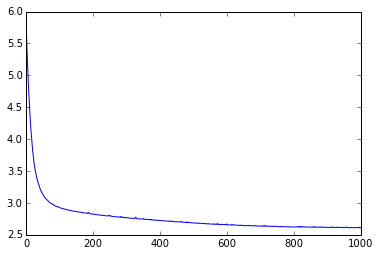

In [15]:
cnn = MiniPacmanHCNN(H, W, l2_reg=0.0, step_size=1e-3)
train_errors = []
for it in range(1000):
    cnn.train(x0, y0, num_iter=10)
    train_errors.append(np.sqrt(cnn.mse(x0, y0)))
plt.plot(train_errors)
print 'training = ', np.sqrt(cnn.mse(x0, y0))
print 'mse = ', np.sqrt(cnn.mse(x0_t, y0_t))

##### Note
This result is produced using separate network for $b$ and $g$, and combining them through a linear layer.

Compiling fprop
Compiling backprop
done
training =  1.98634270502
mse =  3.2671007808


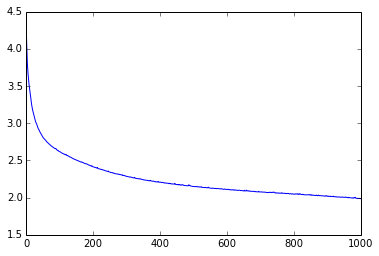

In [21]:
from task.minipacman import MiniPacmanHCNN2
cnn = MiniPacmanHCNN2(H, W, l2_reg=0.0, step_size=1e-3)
train_errors = []
for it in range(1000):
    cnn.train(x0, y0, num_iter=10)
    train_errors.append(np.sqrt(cnn.mse(x0, y0)))
plt.plot(train_errors)
print 'training = ', np.sqrt(cnn.mse(x0, y0))
print 'mse = ', np.sqrt(cnn.mse(x0_t, y0_t))

In [17]:
x0[0, 2:3, :, :].reshape(8,8)

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [ ]:
cnn.